In [1]:
# demo using ResNet-18 model with subset of VGGFACE2 dataset 
import os
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader
from torch.autograd import grad 
import torchvision 
from torchvision import datasets, transforms 
from torchvision.utils import save_image 
import torchvision.models as models 
import inversefed 
from utils.stackeddata import StackedData

# gpu 
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [2]:
data_root = 'data/vggface2' # dir to store data
mean, std = [0.6094151735305786, 0.45365720987319946, 0.38019034266471863], [0.24668121337890625, 0.21547956764698029, 0.20683947205543518]
dm = torch.as_tensor(mean)[:, None, None].to(device)
ds = torch.as_tensor(std)[:, None, None].to(device)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)])
dataset = datasets.ImageFolder(data_root , transform=transform) # subset 100 classes of data 
classes = dataset.classes
data_shape = dataset[0][0].shape
model_checkpoint = 'models/vggface2_models/cp_20.pth' # weights 
model = models.resnet18()
model.fc = nn.Linear(512, len(classes))
model = model.to(device)
model.load_state_dict(torch.load(model_checkpoint))
model.eval() 
criterion = nn.CrossEntropyLoss() 

Ground truth label: n000940 Ground truth model prediction: n004244


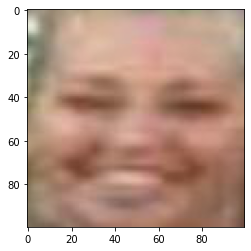

In [3]:
idx = 777 
gt_data, gt_label = dataset[idx]
gt_data = gt_data.unsqueeze(dim=0).to(device)
with torch.no_grad(): 
    model.zero_grad() 
    gt_prediction = model(gt_data)
    
# original data 
plt.imshow((gt_data[0].cpu() * ds.cpu() + dm.cpu()).permute(1,2,0))
print('Ground truth label: {} Ground truth model prediction: {}'.format(classes[gt_label], classes[torch.max(gt_prediction, axis=1)[1]]))

In [6]:
# create stacked data
stacked = StackedData(stack_size=4, model_name='resnet18', dataset_name='vggface2', dataset=dataset, save_output=True, device=device) 
stack_data = stacked.create_stacked_data([idx])

for i in range(len(stack_data['gt_img'])): 
    gt_img, gt_label = stack_data['gt_img'][i], stack_data['gt_label'][i]
    stack_pred = model(gt_img)
    target_loss = criterion(stack_pred, gt_label)
    input_grad = grad(target_loss, model.parameters())
    input_grad =[grad.detach() for grad in input_grad]
    config = dict(signed=True,
              boxed=False,
              cost_fn='sim',
              indices='def',
              norm='none',
              weights='equal',
              lr=0.1, 
              optim='adam',
              restarts=1,
              max_iterations=1200,
              total_variation=0.1,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')
    
    # inverting gradients 
    rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=gt_img.shape[0])
    results = rec_machine.reconstruct(input_grad, gt_label, gt_img ,img_shape=data_shape)
    output_img, stats = results

It: 1200. Rec. loss: 0.0563.
Choosing optimal result ...
Optimal result score: 0.0442
Total time: 108.27462267875671.


Predictions for recontructed images:  ['n000940', 'n004244', 'n000940', 'n004244']


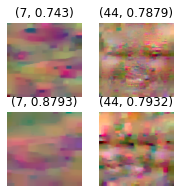

In [7]:
with torch.no_grad(): 
    rec_pred = model(output_img)
    print('Predictions for recontructed images: ', [classes[l] for l in torch.max(rec_pred, axis=1)[1]])
    stacked.grid_plot(idx, output_img, rec_pred, dm, ds)